# Randomized Maximum Likelihood Solver

This notebook demonstrates the use of the Randomized Maximum Likelihood Solver (RML) implemented in the Pastas-Plugins package. It compares three groundwater model calibration approaches:

Least Squares (LS) with noise model

RML with finite-difference Jacobian

RML with empirical Jacobian

The workflow includes generating synthetic observations, defining the Pastas model structure, running calibrations, generating parameter ensembles, and comparing confidence intervals and simulations.

## Setup

### Packages

The notebook imports numerical and hydrological modeling packages:

In [1]:
import warnings
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pastas as ps

from pastas_plugins.pest.solver import RandomizedMaximumLikelihoodSolver

warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'
/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Data

The notebook loads the Wagna dataset and extracts evaporation and precipitation. These serve as input stresses for the RechargeModel.

In [2]:
df = ps.load_dataset("collenteur_2021")["wagna"]
evap = df["evaporation [mm/d]"].rename("evaporation").dropna()
prec = df["precipitation [mm/d]"].rename("precipitation").loc[evap.index]

### Helper functions

Some helper functions to quickly setup models and synthetic series

In [3]:
def get_model(obs: pd.Series) -> ps.Model:
    """Creates a standard Pastas model template.

    Adds a RechargeModel with a Gamma response function.

    Parameters
    ----------
    obs : pd.Series
        Observations series for the model.

    Returns
    -------
    ps.Model
        The model with RechargeModel and noise model configured.
    """
    ml = ps.Model(obs, name="synthetic_model")
    sms = []
    rm = ps.RechargeModel(
        prec=prec,
        evap=evap,
        rfunc=ps.Gamma(),
        name="rch",
    )
    sms.append(rm)
    ml.add_stressmodel(sms)
    # ml.add_noisemodel(ps.ArNoiseModel())
    return ml


def create_synthetic_series(
    noise_std: float = 0.0, freq: Literal["D", "14D"] = "D"
) -> pd.Series:
    """Generates a synthetic groundwater head time series.

    Builds a model with known parameters, simulates the head time series,
    adds Gaussian noise, and resamples to the chosen frequency.

    Parameters
    ----------
    noise_std : float, optional
        Standard deviation of Gaussian noise to add to observations, by default 0.0
    freq : Literal["D", "14D"], optional
        Resampling frequency ("D" for daily, "14D" for 14-day), by default "D"

    Returns
    -------
    pd.Series
        Synthetic groundwater head observations with realistic but controlled values.
    """
    date_range = pd.date_range(tmin, tmax, freq="D")
    obs = pd.Series(0.0, index=date_range, name="head_obs")
    ml = get_model(obs)
    ml.set_parameter("rch_A", initial=rch_A)
    ml.set_parameter("rch_n", initial=rch_n)
    ml.set_parameter("rch_a", initial=rch_a)
    ml.set_parameter("rch_f", initial=rch_f)
    ml.set_parameter("constant_d", initial=constant_d)
    sim = ml.simulate(tmin=tmin, tmax=tmax)
    if noise_std > 0.0:
        noise = np.random.default_rng(seed=42).normal(0, noise_std, len(sim))
        sim += noise
    sim = ps.timeseries_utils.pandas_equidistant_sample(sim, freq=freq)

    return sim

### Constants

A number of synthetic constants (e.g., rch_A, rch_n, etc.) define the "true" parameters used later in the synthetic model generation.

In [4]:
constant_d = 5.0
rch_A = 0.5
rch_n = 1.1
rch_a = 250.0
rch_f = -0.8
tmin = pd.Timestamp("1980-01-01")
tmax = pd.Timestamp("2019-12-31")

noise_std = 0.025

### Create a synthetic head series

Model is not optimized yet, initial parameters are used.


<Axes: >

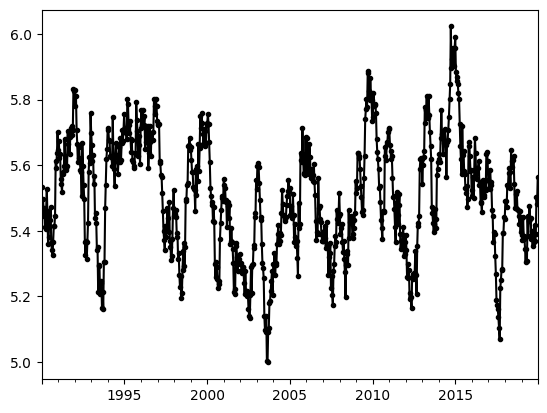

In [5]:
head = create_synthetic_series(noise_std=noise_std, freq="14D")
head = head.loc[pd.Timestamp("1990-01-01") : tmax]
head.plot(marker=".", color="k")

## Models

### Least Squares with Noise Model

A Pastas model (ml_ls) is calibrated with standard least-squares optimization to show as a baseline model to compare the RML uncertainty estimates.

Fit report synthetic_model        Fit Statistics
nfev    11                     EVP         97.94
nobs    783                    R2           0.98
noise   False                  RMSE         0.03
tmin    1990-01-02 00:00:00    AICc     -5762.22
tmax    2019-12-24 00:00:00    BIC      -5738.98
freq    D                      Obj          0.25
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.499871   0.146585  True
rch_n         1.098130   1.000000  True
rch_a       250.819157  10.000000  True
rch_f        -0.807632  -1.000000  True
constant_d    5.008214   5.505771  True


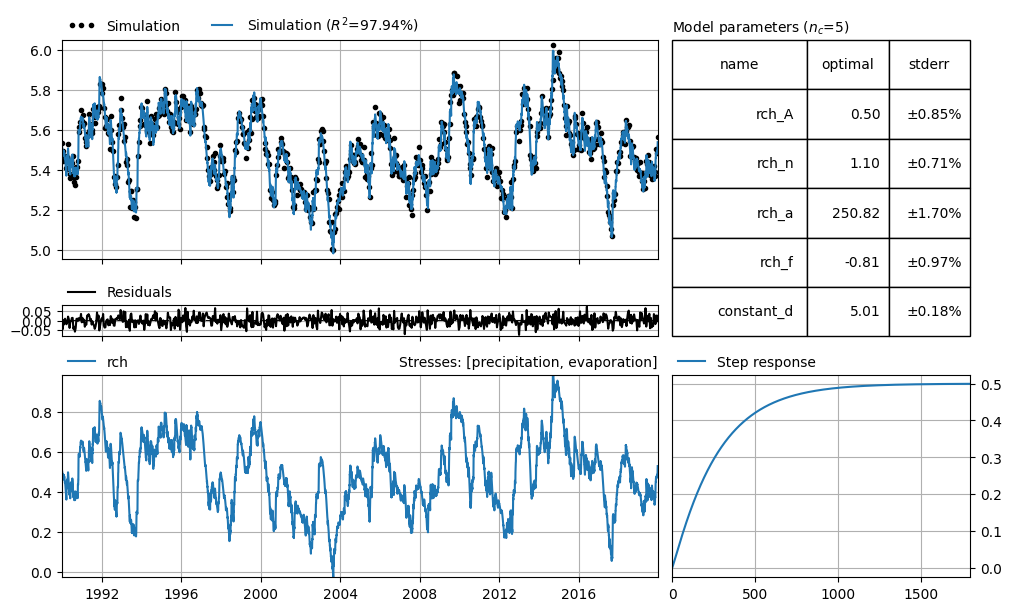

In [6]:
ml_ls = get_model(head)
ml_ls.solve()
axd = ml_ls.plots.results_mosaic(stderr=True)

### RML with finite difference jacobian

In this section we build a model using the Randomized Maximum Likelihood (RML) approach. We apply parameter bounds to constant_d and instantiate the RandomizedMaximumLikelihoodSolver with:
- 1000 realizations, forming the RML parameter ensemble
- A three-point finite-difference Jacobian
    - This means each realization performs its own independent optimization starting from its individually drawn initial parameter set.
    - Each realization computes its own finite-difference Jacobian, just like the standard Pastas least-squares solver.


During `solver.initialize()`, several important steps occur:
- The standard deviation of the observation noise is set via `standard_deviation=noise_std`. This creates a unique synthetic observation series for each ensemble member, representing uncertainty in the measurement data.
- The arguments `method="norm"` and `par_sigma_range=4.0` define how the initial parameter values for each realization are sampled:
    - `method="norm"` → initial parameters are drawn from a normal distribution
    - `par_sigma_range=4.0` → the parameter bounds (pmin, pmax) are interpreted as ±4 standard deviations of this distribution

Together, these settings define the prior parameter ensemble, from which each realization begins its optimization before contributing to the final RML posterior ensemble.

In [7]:
# test finite difference jacobian
ml_rml = get_model(head)
ml_rml.set_parameter(
    "constant_d",
    pmin=ml_rml.parameters.at["constant_d", "initial"]
    - 3 * ml_rml.observations().std(),
    pmax=ml_rml.parameters.at["constant_d", "initial"]
    + 3 * ml_rml.observations().std(),
)

solver = RandomizedMaximumLikelihoodSolver(
    num_reals=1000,
    jacobian_method="3-point",
    # num_workers= # if you want to do stuff in parallel, by default yes. if not set num_workers to 1.
)
ml_rml.add_solver(solver)
solver.initialize(
    standard_deviation=noise_std,
    method="norm",
    par_sigma_range=4.0,
)  # method="truncnorm"


Let's have a look at the prior parameter ensemble.

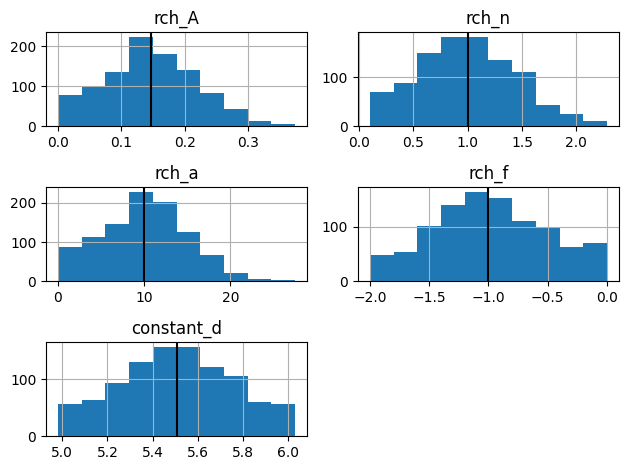

In [8]:
parameter_ensemble_initial = solver.parameter_ensemble.copy()
axes = parameter_ensemble_initial.hist(bins=10)
for ax in axes.ravel():
    title = ax.get_title()
    if title != "":
        ax.axvline(ml_rml.parameters.at[title, "initial"], color="k", label="initial")
plt.tight_layout()

The observation_noise is stored under the `solver.observation_noise`:

In [9]:
solver.observation_noise.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,base
1990-01-02,0.006134,0.013955,0.013881,0.004524,0.048632,0.029283,0.071084,0.031424,0.035165,-0.034352,...,-0.022094,0.024990,-0.014745,0.008126,0.019464,0.025633,-0.016064,0.014447,0.024804,0.0
1990-01-16,0.036680,0.001687,-0.004078,-0.023111,0.011612,-0.007555,0.001709,-0.031365,0.025758,0.006708,...,0.001495,-0.011008,-0.004277,0.006085,0.001768,-0.007239,0.024667,0.030998,0.028296,0.0
1990-01-30,-0.047690,0.002048,0.038367,0.047704,-0.030420,0.044077,0.049584,-0.012265,0.110637,0.048410,...,-0.029416,0.007900,-0.013474,0.008750,0.017443,0.020095,-0.019823,0.013809,0.005943,0.0
1990-02-13,-0.004727,-0.010877,0.007530,0.000116,-0.005697,-0.003180,0.023199,0.010812,0.013132,-0.036098,...,-0.006242,0.031360,-0.004954,-0.037245,-0.023591,-0.020573,0.002072,0.020751,0.009445,0.0
1990-02-27,0.041191,0.036230,0.030532,-0.007042,-0.053829,-0.033103,0.004161,0.013498,0.024674,-0.020831,...,-0.001246,0.018653,0.014736,0.014010,0.020096,-0.034195,-0.001712,-0.009853,0.010157,0.0


Together with the `ml.observations()` the observation_noise forms the `solver.observation_ensemble` on which each ensemble is fitted.

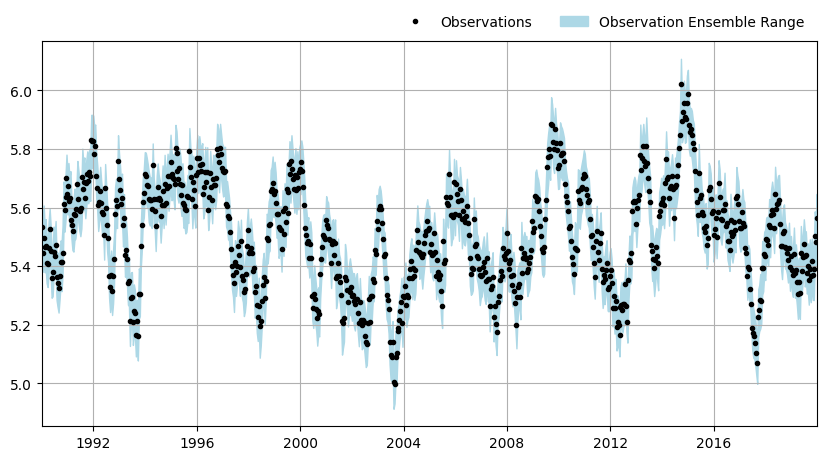

In [10]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    ml_rml.observations().index,
    ml_rml.observations().values,
    "k.",
    label="Observations",
)
ax.fill_between(
    ml_rml.solver.observation_ensemble.index,
    ml_rml.solver.observation_ensemble.min(axis=1),
    ml_rml.solver.observation_ensemble.max(axis=1),
    color="lightblue",
    label="Observation Ensemble Range",
)

ax.set_xlim(ml_rml.observations().index.min(), ml_rml.observations().index.max())
ax.grid(True)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 1.0), ncol=2, frameon=False)

Let's solve this. It might take a minute or if it is done in parallel.

In [11]:
ml_rml.solve(solver=solver, report=True)

RML looping over realizations: 100%|██████████| 1000/1000 [01:43<00:00,  9.70it/s]


Fit report synthetic_model                      Fit Statistics
nfev    1000                   EVP                       97.94
nobs    783                    R2                         0.98
noise   False                  RMSE                       0.03
tmin    1990-01-02 00:00:00    AICc                   -5762.22
tmax    2019-12-24 00:00:00    BIC                    -5738.98
freq    D                      Obj                         nan
warmup  3650 days 00:00:00     ___                            
solver  RandomizedMaximumLikelihoodSolverInterp.                      No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.499872   0.146585  True
rch_n         1.098129   1.000000  True
rch_a       250.819485  10.000000  True
rch_f        -0.807632  -1.000000  True
constant_d    5.008214   5.505771  True


Lets look at the posterior parameter distribution.

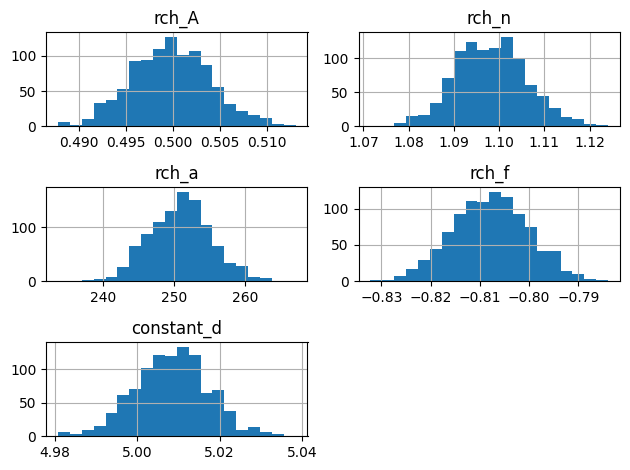

In [12]:
ml_rml.solver.parameter_ensemble.hist(bins=20)
plt.tight_layout()

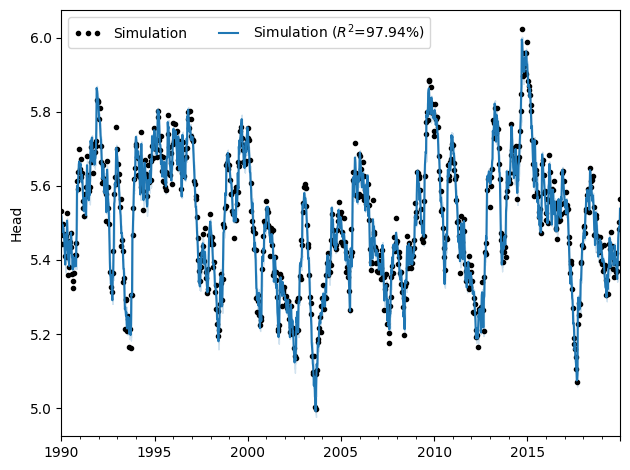

In [13]:
ax = ml_rml.plot()
ax.fill_between(
    ml_rml.solver.simulation_ensemble.index,
    ml_rml.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=0.2,
    color="C0",
)

### RML with empirical jacobian

In [14]:
# test empirical jacobian
ml_rml_em = get_model(head)
ml_rml_em.del_noisemodel()
ml_rml_em.set_parameter(
    "constant_d",
    pmin=ml_rml_em.parameters.at["constant_d", "initial"]
    - 3 * ml_rml_em.observations().std(),
    pmax=ml_rml_em.parameters.at["constant_d", "initial"]
    + 3 * ml_rml_em.observations().std(),
)

solver = RandomizedMaximumLikelihoodSolver(
    num_reals=100, jacobian_method="empirical", noptmax=25
)
ml_rml_em.add_solver(solver)
solver.initialize(standard_deviation=noise_std, method="norm")
ml_rml_em.solve(solver=solver, report=True)

RML looping over noptmax: 100%|██████████| 25/25 [01:07<00:00,  2.69s/it]

Fit report synthetic_model                      Fit Statistics
nfev    25                     EVP                        2.76
nobs    783                    R2                         0.03
noise   False                  RMSE                       0.17
tmin    1990-01-02 00:00:00    AICc                   -2742.34
tmax    2019-12-24 00:00:00    BIC                    -2719.11
freq    D                      Obj                         nan
warmup  3650 days 00:00:00     ___                            
solver  RandomizedMaximumLikelihoodSolverInterp.                      No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.005782   0.146585  True
rch_n         0.100000   1.000000  True
rch_a       233.113534  10.000000  True
rch_f        -2.000000  -1.000000  True
constant_d    5.512039   5.505771  True

Warnings! (2)
Parameter 'rch_n' on lower bound: 1.00e-01
Parameter 'rch_f' on lower bound: -2.00e+00


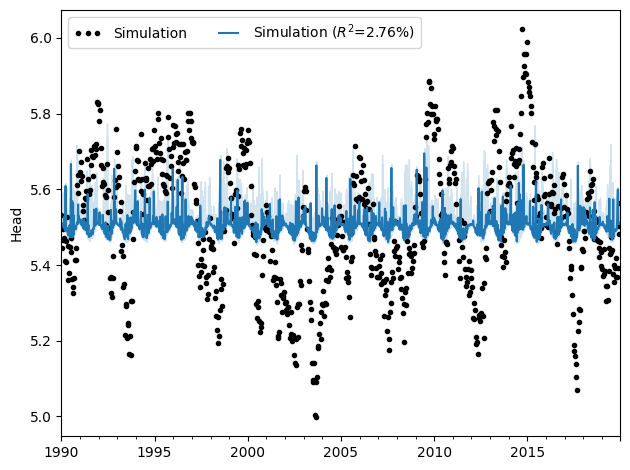

In [15]:
ax = ml_rml_em.plot()
ax.fill_between(
    ml_rml_em.solver.simulation_ensemble.index,
    ml_rml_em.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml_em.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=0.2,
    color="C0",
)

## Compare CI

In [16]:
ls_ci = pd.DataFrame(
    [
        ml_ls.parameters["optimal"] - 1.96 * ml_ls.parameters["stderr"],
        ml_ls.parameters["optimal"] + 1.96 * ml_ls.parameters["stderr"],
    ],
    index=[0.025, 0.975],
)
rml_ci = ml_rml.solver.parameter_ensemble.quantile([0.025, 0.975])
rmlem_ci = ml_rml_em.solver.parameter_ensemble.quantile([0.025, 0.975])
df = pd.concat([ls_ci, rml_ci, rmlem_ci], keys=["LS", "RML", "RML-EM"], axis=1).T
df.swaplevel(0, 1).sort_index()

0.025       0.975
constant_d LS        4.990131    5.026296
           RML       4.990625    5.026053
           RML-EM    5.510463    5.513660
rch_A      LS        0.491571    0.508172
           RML       0.492369    0.508526
           RML-EM    0.005444    0.006213
rch_a      LS      242.486386  259.151928
           RML     242.660130  259.645112
           RML-EM  213.508065  250.959074
rch_f      LS       -0.822946   -0.792318
           RML      -0.822795   -0.793019
           RML-EM   -2.000000   -2.000000
rch_n      LS        1.082913    1.113347
           RML       1.082656    1.114124
           RML-EM    0.100000    0.100000

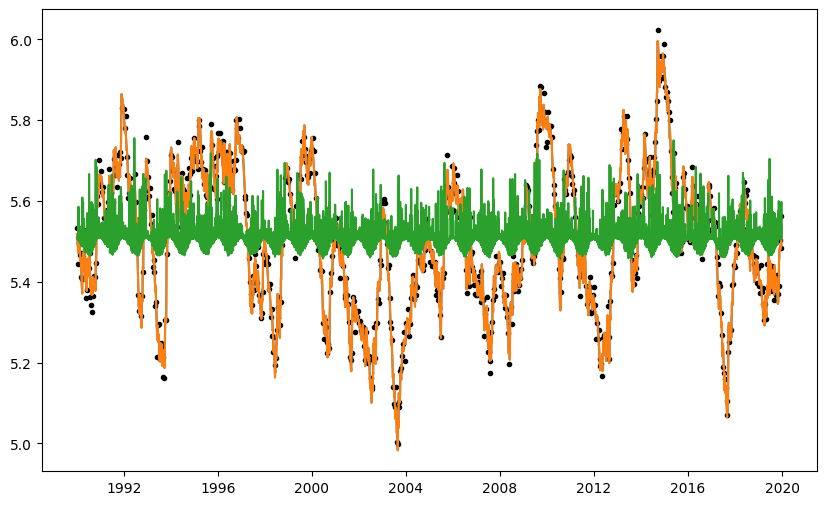

In [17]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    ml_ls.observations(), label="Observations", color="k", linestyle="None", marker="."
)
ax.plot(ml_ls.simulate(), color="C0")
ax.plot(ml_rml.simulate(), color="C1")
ax.plot(ml_rml_em.simulate(), color="C2")